# NE 204 Lab 1 - Fitting Trapezoidal Filter Params

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib nbagg

import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy.integrate as integrate
from scipy.optimize import curve_fit
import scipy.signal
from scipy.signal import find_peaks, peak_prominences

# import tool repo
import sys

# UPDATE PATH TO PATH WHERE YOU HAVE REPO SAVED
sys.path.append('/Users/kalie/courses/ne204/lab/kalieknecht_lab1')
from tools import find_activity, import_data, subtract_baseline
from filters import fit_tau, fit_taus, JordanovFilter, BogovacFilter, CooperFilter
from spectrum import spectrum

In [2]:
# # function imports data, removes duplicate events, and converts to np.int16
# # type conversion to np.int16 takes some time


print('cs calibration')
f_name = '../data/cs.h5'
f_data = h5py.File(f_name,'r')
cs = f_data['raw_data'][()]
cs_events = f_data['event_data'][()]
print(str(cs.shape[0])+' events')

print('co calibration')
f_name = '../data/co.h5'
f_data = h5py.File(f_name,'r')
co = f_data['raw_data'][()]
co_events = f_data['event_data'][()]
print(str(co.shape[0])+' events')

print('ba calibration')
f_name = '../data/ba.h5'
f_data = h5py.File(f_name,'r')
ba = f_data['raw_data'][()]
ba_events = f_data['event_data'][()]
print(str(ba.shape[0])+' events')

# # pulser noise data
# f_name = '../data/pulser.h5'
# f_data = h5py.File(f_name,'r')
# noise = f_data['raw_data'][()]
# noise_events = f_data['event_data'][()]
# print(str(noise.shape[0])+' events')

cs calibration
152057 events
co calibration
138945 events
ba calibration
8822 events
5634 events


In [3]:
# downsample data and add it together for filter parameter fitting
cs_down = cs[::10]
co_down = co[::10]
ba_down = ba
len(cs_down)+len(co_down)+len(ba_down)

37923

In [4]:
raw_waveforms = np.vstack((cs_down,co_down,ba_down))

In [ ]:
# raw_bkg = subtract_baseline(raw_waveforms)

# fit tau

In [5]:
# first downsample data a reasonable amount
cs_down = cs_bkg[::100]
cs_down.shape

(9131, 5000)

In [ ]:
tauvals = fit_taus(cs_down)
tauvals.mean(), tauvals.std()

<IPython.core.display.Javascript object>


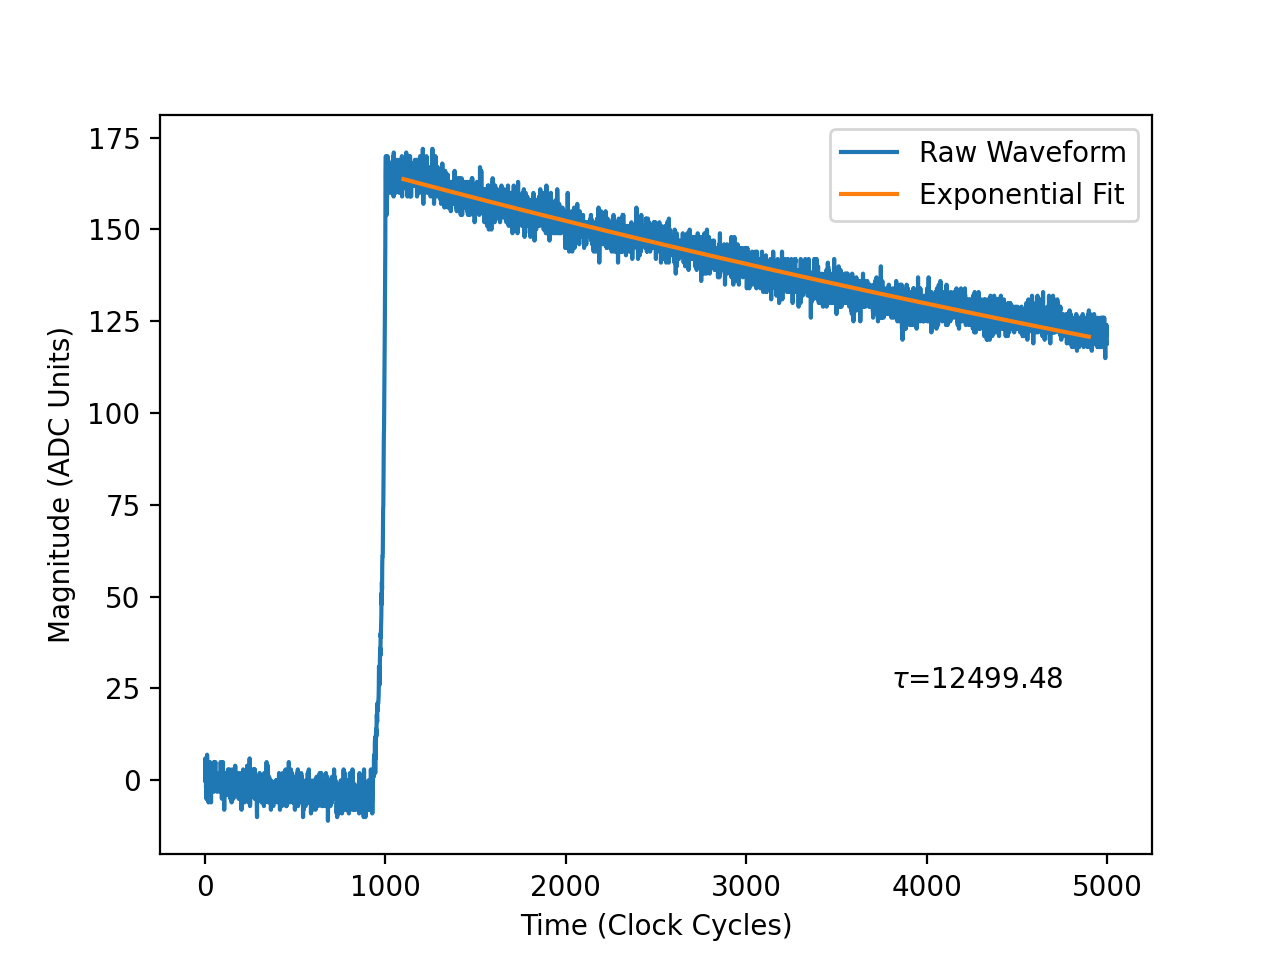

12499.475104450019

In [6]:
# example of good fit
fit_tau(cs_down[0],show_plot=True)

In [ ]:
# we want to remove piled up pulses from our tau fit
# piled up pulses typically have large tau, or negative tau
mask = tauvals < 2e4 # less than 15000
mask *= tauvals > 5e3 # at least 1000
good_tau_pulses = cs_down[mask]

tau_fixed = fit_taus(good_tau_pulses)
bad_tau_pulses = cs_down[~mask]
good_tau_pulses = cs_down[mask]
bad_tau_pulses.shape

<IPython.core.display.Javascript object>


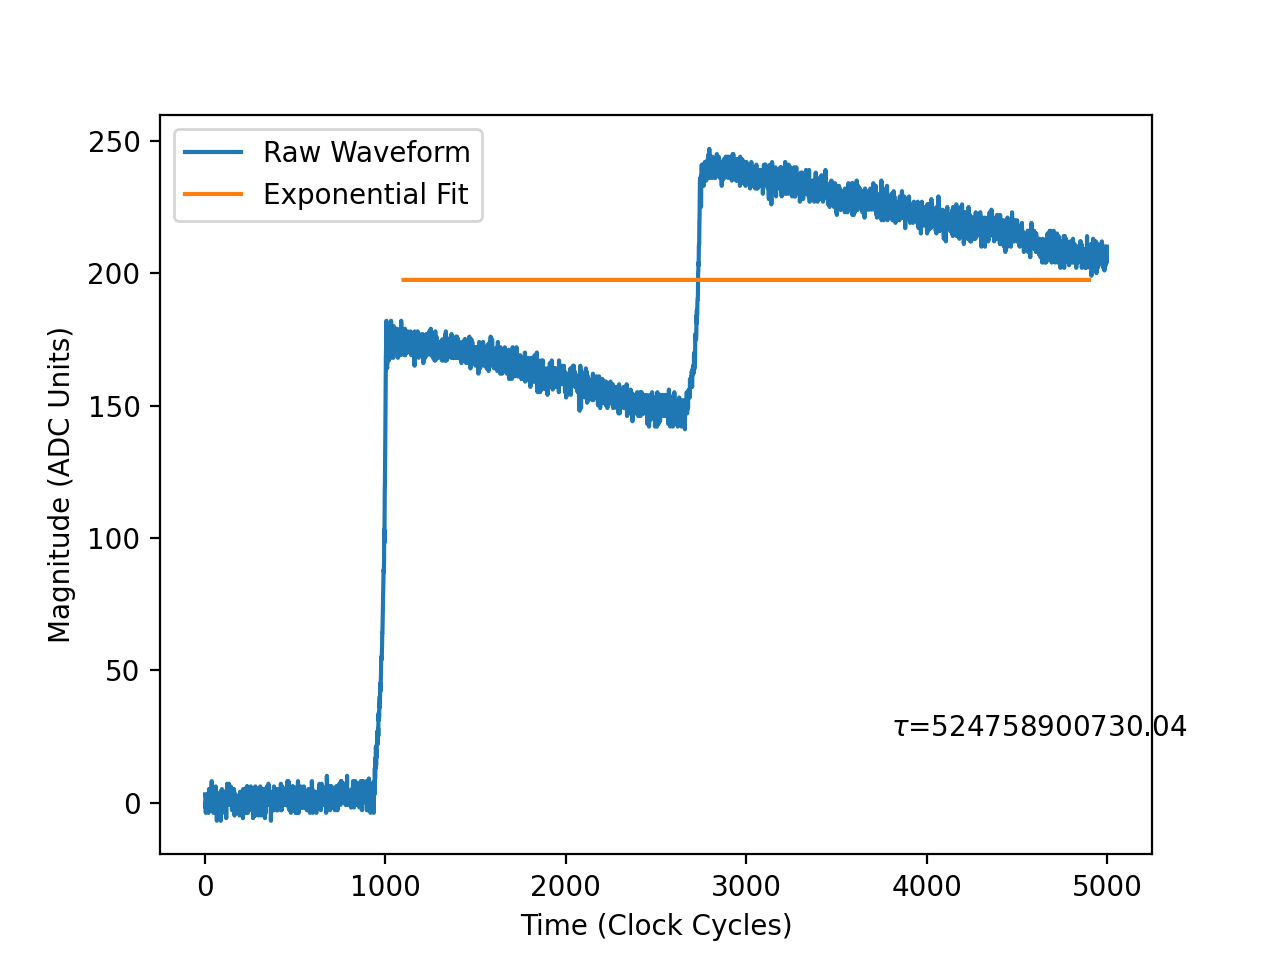

524758900730.0444

In [7]:
fit_tau(bad_tau_pulses[5],show_plot=True,plot_save_name='../figs/tau_fit_pileup.png')

In [ ]:
plt.figure()
for i in range(len(bad_tau_pulses)):
    plt.plot(bad_tau_pulses[i])
plt.show()

<IPython.core.display.Javascript object>


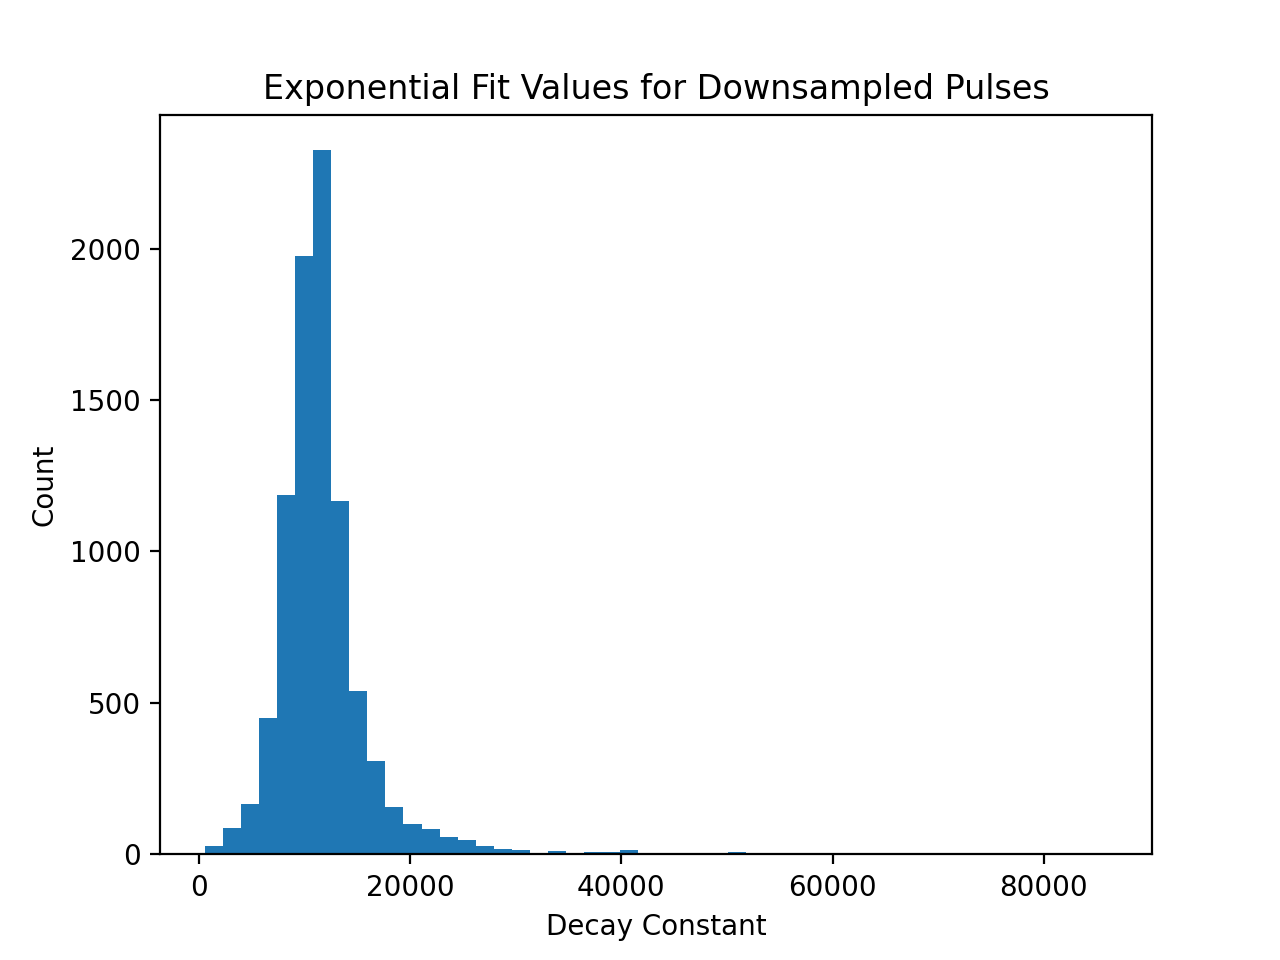

In [16]:
plt.figure()
plt.hist(tau_fixed,bins=50)
plt.xlabel('Decay Constant')
plt.ylabel('Count')
plt.title('Exponential Fit Values for Downsampled Pulses')
plt.show()

In [8]:
tau = tau_fixed.mean()
peaking_time = 100 * 4 * 10**(-9)#1.6e-6/2
#peaking_time = 100 * 4 * 10**(-9) * 10
gap_time = peaking_time * 10  #6.4e-6/4

tau, peaking_time, gap_time

mean and variance: 5641226553.945128 1.42101424495566e+21


In [ ]:
# # use tau to filter pileup out of data
# all_taus = fit_taus(cs_bkg)

# mask = all_taus < 2e4
# mask *= all_taus > 1e3
# filtered_cal_pulses = cs_bkg[mask]
# print(filtered_cal_pulses.shape)

# filtered_cal_pulses_down = filtered_cal_pulses[::10]
# print(filtered_cal_pulses_down.shape)

In [ ]:
plt.figure()

iter = 0
for idx, val in enumerate(trap_heights):
    if val > 4.7 * 10**(16):
        if val < 5.1 * 10 ** (16):
            iter = iter + 1
            if iter < 50:
                plt.plot(filtered_waves[idx])
                #iter = iter + 1
plt.show()

In [ ]:
pileups = np.ones(len(filtered_waves), dtype=bool)
for idx, val in enumerate(filtered_waves):
    if not all(i <= 10**15 for i in val[2000:]):
        pileups[idx] = False
    

In [ ]:
def determine_rise(signal, sigma=8, window=20, offset=100):
    # Input filtered signal, returns index of start of rise on pulse
    noise_samp = signal[:500]
    mean, std = np.mean(noise_samp), np.std(noise_samp)

    grad = np.gradient(np.where(signal > mean+sigma*std, signal, 0))

    grad_pos, grad_neg = np.argwhere(grad>2), np.argwhere(grad<-2)

    rise_start = 0
    for gp in grad_pos:
        close = False
        for gn in grad_neg:
            if gn-gp < window and gn-gp > 0:
                close = True
        if not close:
            rise_start = gp
            break

    return int(rise_start-offset)

In [ ]:
determine_rise(calibration_bkg[0])

In [ ]:
def dkl(signal, i, k, l, w):
    """
    Calculates dkl value given a signal,
        i = index of start of rise
        k = peaking time
        l = peaking time + gap time
        w = width of window to sample on pulse (trapezoid output width)
    """
    signal = delay_signal(signal, delay=w)
    vj = signal[i+w:i+w+w]
    vjk = signal[i-k+w:i+w+w-k]
    vjl = signal[i-l+w:i+w+w-l]
    vjkl = signal[i-k-l+w:i+w+w-k-l]
    return vj - vjk - vjl + vjkl

## To do  - get full pipeline working to optimize peak and gap time
see https://docs.google.com/spreadsheets/d/1K7WjIuMFDT9hBYbCPu7D8rVkpYy9y08XVx23aaCvyjQ/edit?usp=sharing

In [179]:
# relevant gamma energies
energies=[356.0129, 661.7,  1173.228, 1332.492]
compton_edges = np.array([477.,963.,1118.])
# k40 and tl208
background_peaks = np.array([1460.820,1764,2614.511])
possible_pileups = np.array([1173.228+1332.492,662*2,1173.228*2,1332.492*2])

# save as tau for filter
#tau = tau_fixed.mean()
tau = 10967.425786005182
tau = tau * 4 * 10**(-9)

peaking_time = 100 * 4 * 10**(-9)#1.6e-6/2
#peaking_time = 100 * 4 * 10**(-9) * 10
gap_time = peaking_time * 5.5  #6.4e-6/4

tau, peaking_time, gap_time

(4.3869703144020734e-05, 4.0000000000000003e-07, 2.2e-06)

In [180]:
Cooper_filter = CooperFilter(peaking_time, gap_time, tau)

In [181]:
filtered_waveforms = Cooper_filter.filter_waveform(raw_waveforms[::2],normalize=True)

In [182]:
spec = spectrum(filtered_waveforms,bins=2000)

Finding Peaks


<IPython.core.display.Javascript object>


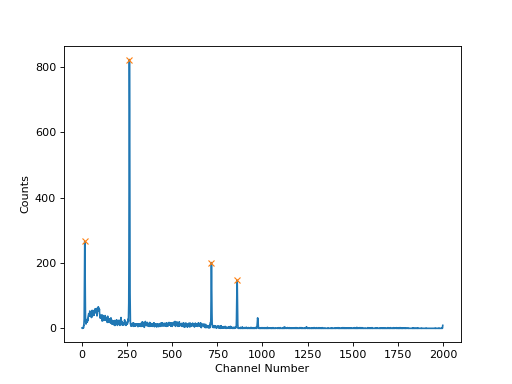

In [183]:
prominence = 70
width =[0,20]
spec.find_gamma_peaks(show_plot=True,prominence=prominence,width=width)

In [177]:
spec.peaks

array([ 21, 268, 720, 862])

In [184]:
spec.run_full_pipeline(energies,prominence=prominence,width=width)

Finding Peaks
Finding energy calibration
Finding energy resolution calibration
Done!
fwhms: [4.57382608 4.47594105 4.44688052 4.59563697]


<IPython.core.display.Javascript object>


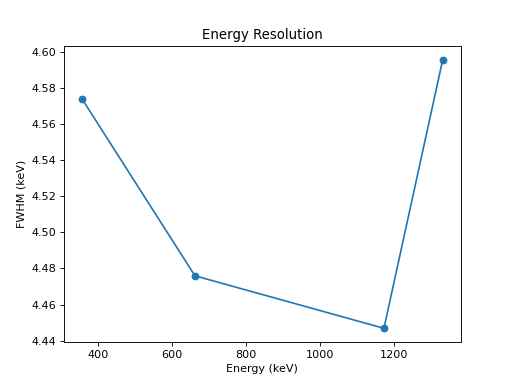

In [185]:
spec.plot_energy_resolution()

<IPython.core.display.Javascript object>


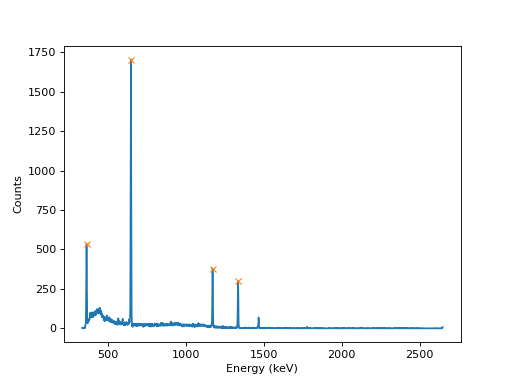

<IPython.core.display.Javascript object>


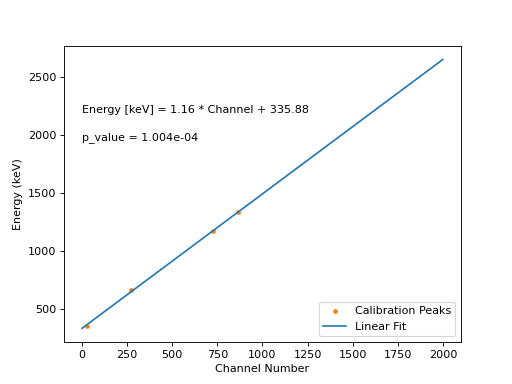

Energy [keV] = 1.16 * Channel + 335.88


<IPython.core.display.Javascript object>


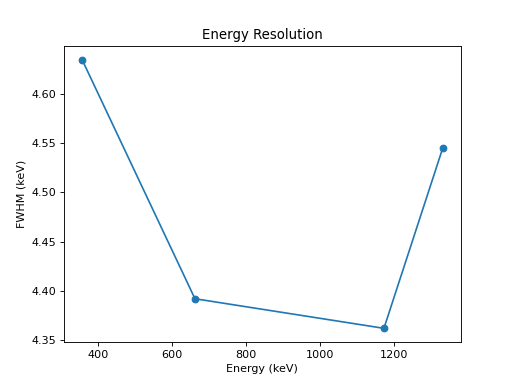

In [32]:
# see spectrum with x-axis as energy
spec.plot_spectrum()
# visualize energy calibration
spec.plot_energy_calibration(show_equation=True)
# visualize  FWHMs
spec.plot_energy_resolution()

<IPython.core.display.Javascript object>


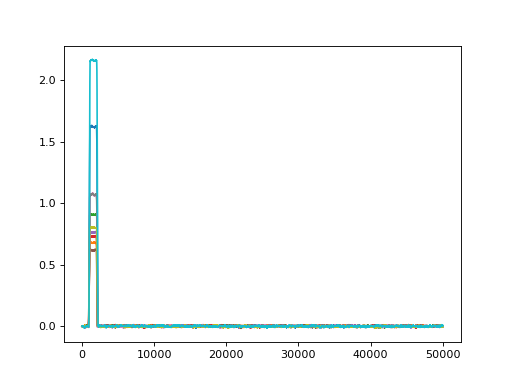

In [18]:
# plot random trapezoids
# number of random pulses
number_of_pulses = 10
plt.figure()
for i in range(number_of_pulses):
    n = int(np.random.rand()*len(filtered_waveforms))
    plt.plot(filtered_waveforms[n])
#plt.xlim(920,1150)
plt.show()